# Обработка изображения с шумами 
## random ИЛИ соль+перец ИЛИ оба частотными фильтрами

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from lib.helpersmd import readFromDat
%matplotlib inline

In [2]:
import numpy as np
import os
import cv2
def noisy(image):
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.0004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    return out

In [3]:
def medianFilter(model,startx,endx,starty,endy):
    block=model[startx:endx,starty:endy].flatten()
    block=np.sort(block)
    return block[block.shape[0]/2]
def meanFilter(model,startx,endx,starty,endy):
    block=model[startx:endx,starty:endy].flatten()
    return block.mean()

#  I - Consturct filters

In [4]:
fl=350
fh=350

## 1. Low pass filter

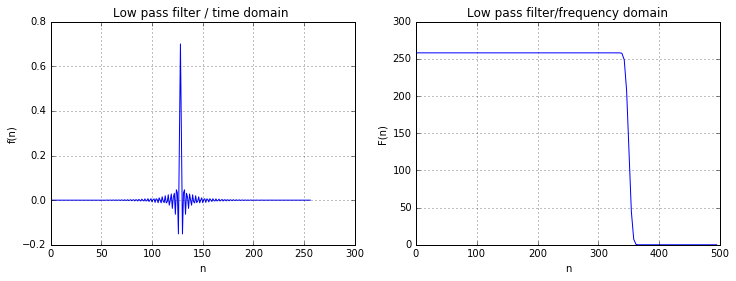

In [5]:
from lib.filtersmd import lpf
from lib.plotmd import plotVector, plot2D
from lib.signalprocessingmd import fourierTransform,getScaledDomain

fout=fl
m=128
dt=0.001
N=2*m+1
lpw=lpf(fout,m,dt)
_,Cn_lpw=fourierTransform(lpw)
Cn_lpw=Cn_lpw[:N/2]
Cn_lpw=Cn_lpw*(N+1)
fscaled=getScaledDomain(dt,N)[:N/2]

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plotVector(lpw,"Low pass filter / time domain ","n","f(n)")
plt.subplot(122)
plot2D(fscaled,Cn_lpw,"Low pass filter/frequency domain","n","F(n)")
plt.show()

## 2. High pass filter

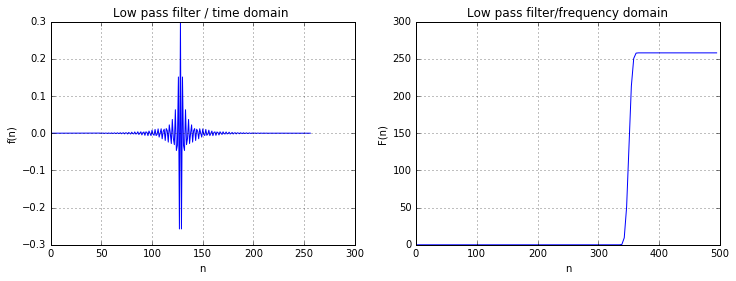

In [6]:
from lib.filtersmd import hpf
fc=fh
hpw=hpf(fc,m,dt)
_,Cn_hpw=fourierTransform(hpw)
Cn_hpw=Cn_hpw[:N/2]*(N+1)
fscaled=getScaledDomain(dt,N)[:N/2]

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plotVector(hpw,"Low pass filter / time domain ","n","f(n)")
plt.subplot(122)
plot2D(fscaled,Cn_hpw,"Low pass filter/frequency domain","n","F(n)")
plt.show()


----------------

## II - Load image

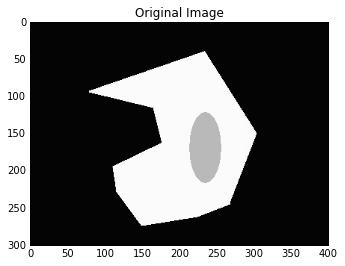

In [7]:
from PIL import Image
model = np.array(Image.open("./data/MODEL.jpg"))
model = (model-model.min())
size=model.shape
plt.figure()
plt.title('Original Image')
imshow(model,cmap='gray')

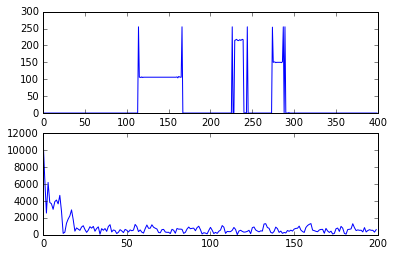

In [8]:
# row original
row=model[123,:]-model[223,:]
_,Cn=fourierTransform(row)
Cn=Cn[:Cn.shape[0]/2]
plt.figure()
plt.subplot(2,1,1)
plt.plot(row)
plt.subplot(2,1,2)
plt.plot(Cn)

-------------

## III - Add noise  

### 1. add White noise

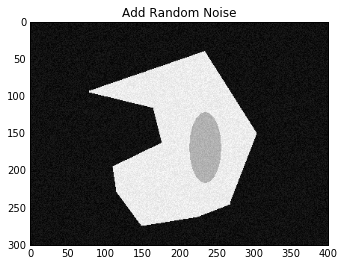

In [9]:
prob=np.random.randint(0,100,size)<101
ns=np.multiply(prob,np.random.randint(-10,10,size))
noiseimg1=model+ns
noiseimg1=noiseimg1-noiseimg1.min()
plt.figure()
plt.title('Add Random Noise')
imshow(noiseimg1,cmap='gray')

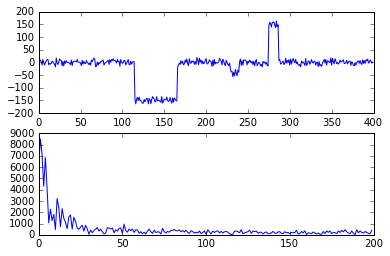

In [10]:
# row noisy
row=noiseimg1[123,:]-noiseimg1[223,:]
_,Cn2=fourierTransform(row)
Cn2=Cn2[:Cn2.shape[0]/2]
plt.figure()
plt.subplot(2,1,1)
plt.plot(row)
plt.subplot(2,1,2)
plt.plot(Cn2)

### 2. соль и перец

In [11]:
#prob=np.random.randint(0,100,size)
#noiseimg1=noisy(model)
#plt.figure()
#plt.title("Salt-pepper Noise")
#imshow(noiseimg1,cmap='gray')

## IV - LPF

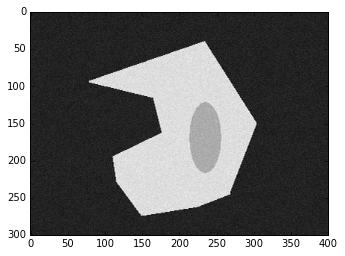

In [12]:
from lib.signalprocessingmd import convolution
lpw_image=np.zeros_like(noiseimg1)
for i in range(lpw_image.shape[0]):
    lpw_image[i,:]=convolution(noiseimg1[i,:],lpw)[m:-m]
plt.figure()
plt.show("Low Pass Filter")
imshow(lpw_image,cmap='gray')

## V - HPF

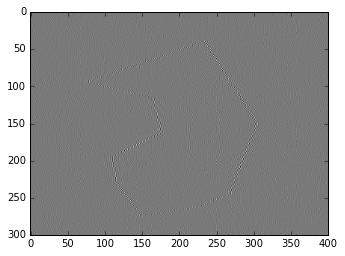

In [13]:
from lib.signalprocessingmd import convolution
hpw_image=np.zeros_like(noiseimg1)
for i in range(hpw_image.shape[0]):
    hpw_image[i,:]=convolution(noiseimg1[i,:],hpw)[m:-m]
plt.figure()
imshow(hpw_image,cmap='gray')

# VI Substract the images after applying filters

(0, 243)


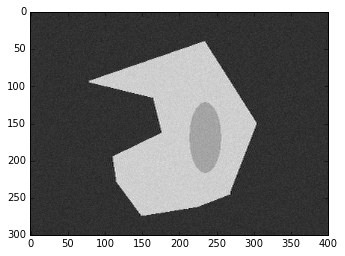

In [14]:
subst=lpw_image-hpw_image
subst=subst-subst.min()
subst=subst.astype('uint8')
print(subst.min(),subst.max())
plt.figure()
imshow(subst,'gray')

## VII Threshold transform

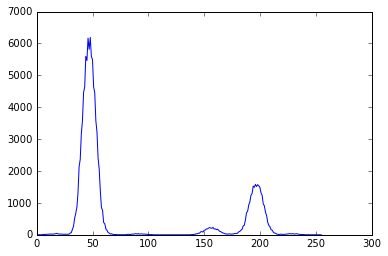

In [15]:
hist=[np.sum(subst==i) for i in range(256)]
plt.figure()
plt.plot(hist)

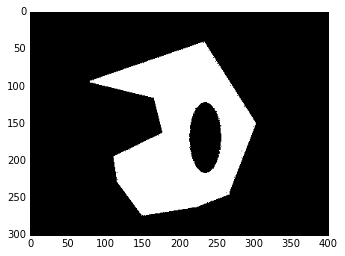

In [16]:
threshold=176
final=np.copy(subst)
final[final<threshold]=0
final[final>=threshold]=255
plt.figure()
imshow(final,cmap='gray')